In [2]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import CVRPEnv, CVRPTWEnv
from rl4co.models.nn.utils import rollout, random_policy
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
scale = False
env = CVRPTWEnv(
    num_loc=20,
    min_loc=0,
    max_loc=150,
    min_demand=1,
    max_demand=10,
    vehicle_capacity=1,
    capacity=10,
    min_time=0,
    max_time=480,
    scale=scale,
)

Start rollout...
Done.
Finished run with reward:
 tensor([-2982.4963, -2476.8958, -2823.1755]) 
actions:
 tensor([[15, 14,  0, 18, 17,  0,  2,  0,  8,  9,  0, 11,  5,  0, 12,  0,  1,  0,
          3, 16,  0,  4,  0, 13, 19,  0,  7,  0,  6, 10,  0, 20],
        [12, 13,  0,  2,  0, 10, 18,  0, 19,  5,  0, 11, 20,  8,  0, 16,  4,  0,
          7, 15,  0,  3,  0, 14,  0,  9,  0, 17,  0,  6,  0,  1],
        [18,  0, 13, 10,  0, 16, 14,  0, 12,  5, 17,  0,  8,  0,  9,  0,  7,  6,
          0, 20,  0,  2,  0,  1,  0, 19,  4,  0, 15,  0,  3, 11]])


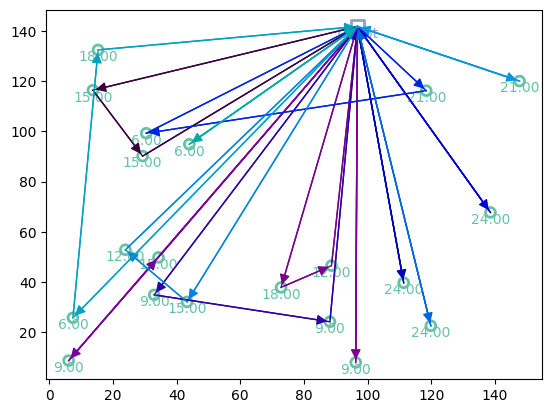

In [4]:
# try random policy with a random instance
batch_size = 3

print("Start rollout...")
reward, td, actions = rollout(
    env=env, td=env.reset(batch_size=[batch_size]), policy=random_policy, max_steps=100
)
print("Done.")
print("Finished run with reward:\n", reward, "\nactions:\n", actions)
env.render(td, actions)

Start attention model...


/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Tour lengths: ['2995.09', '2700.11', '2686.95']


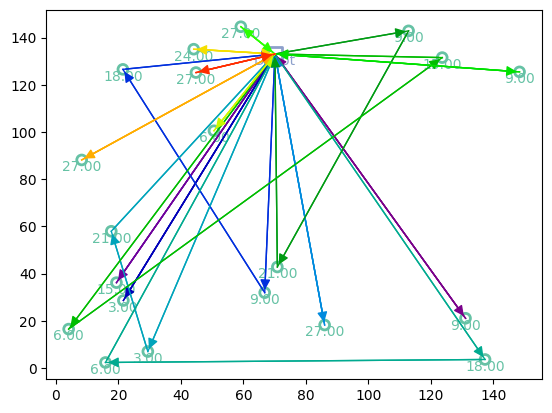

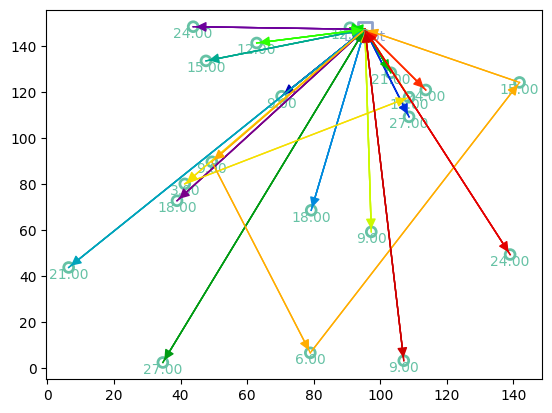

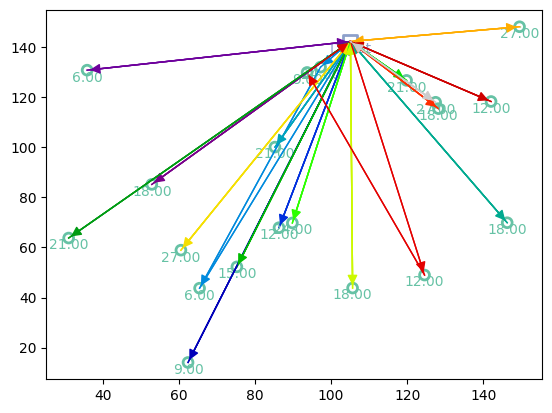

In [5]:
# Model: default is AM with REINFORCE and greedy rollout baseline
print("Start attention model...")
model = AttentionModel(
    env, baseline="rollout", train_data_size=100_000, val_data_size=10_000
)

# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out["actions"].cpu()):
    env.render(td, actions)

### Logging

Here we will use [Wandb](https://wandb.ai/) (make sure to register an account there to keep track on runs remotely). You may comment below lines if you don't want to use it. You may check other loggers here

We make sure we're logged into W&B so that our experiments can be associated with our account. You may comment the below line if you don't want to use it.


---

Other available loggers: https://lightning.ai/docs/pytorch/stable/extensions/logging.html


In [6]:
import wandb
wandb.login()

## Comment following two lines if you don't want logging
from lightning.pytorch.loggers import WandbLogger

logger = WandbLogger(project="routefinder", name="cvrptw-am")


## Keep below if you don't want logging
# logger = None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ngz (rl4co). Use `wandb login --relogin` to force relogin


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | CVRPTWEnv            | 0     
1 | policy   | AttentionModelPolicy | 694 K 
2 | baseline | WarmupBaseline       | 694 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.557     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Tour lengths: ['2084.15', '1992.59', '1975.40']


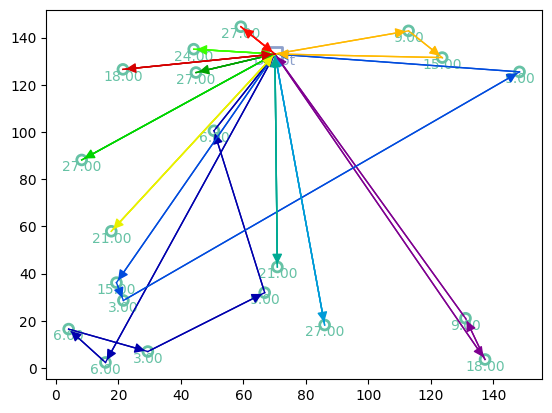

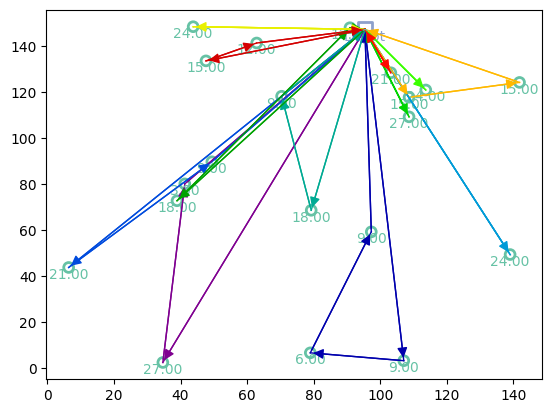

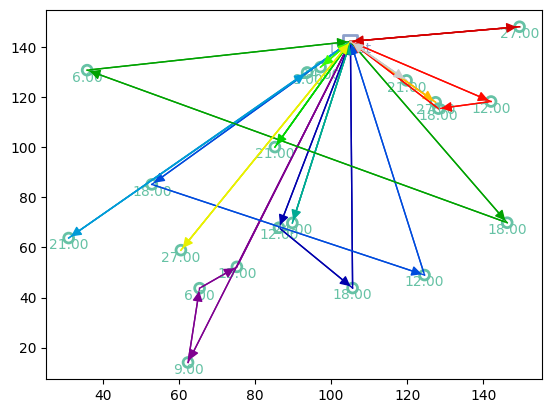

In [7]:
# The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="auto",
    devices=1,
    logger=logger,
)
# fit model
trainer.fit(model)

# Testing

# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out["actions"].cpu()):
    env.render(td, actions)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | CVRPTWEnv            | 0     
1 | policy   | AttentionModelPolicy | 694 K 
2 | baseline | WarmupBaseline       | 694 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.557     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Tour lengths: ['1998.63', '2682.42', '2338.45']


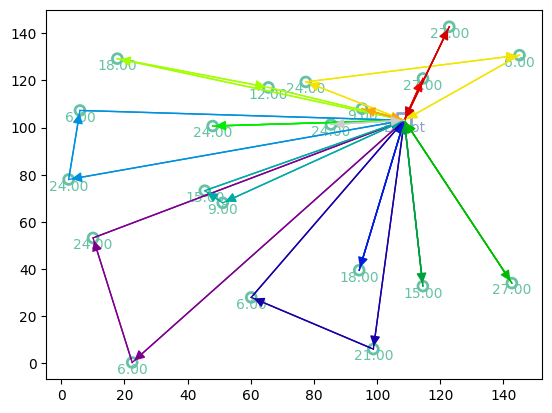

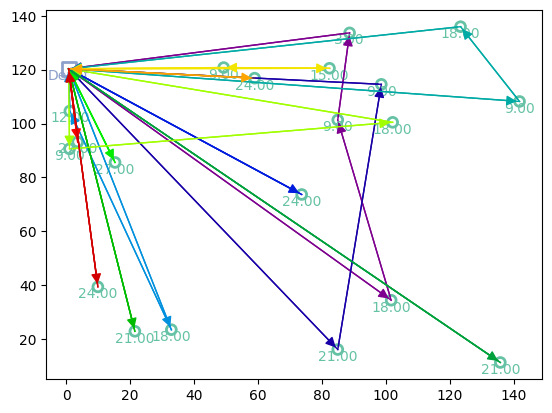

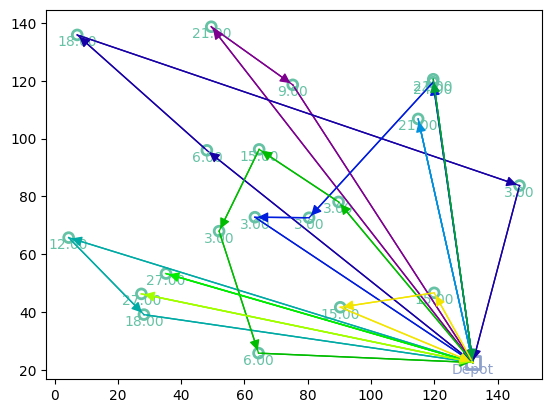

In [12]:
# The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults
trainer = RL4COTrainer(
    max_epochs=30,
    accelerator="auto",
    devices=1,
    logger=logger,
)
# fit model
trainer.fit(model)

# Testing

# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out["actions"].cpu()):
    env.render(td, actions)